Improving the performance of an ML model via hyperparameter optimization is common amongst practitioners of the field. While objects such as `sklearn.GridSearchCV` provide easy interfaces for such tasks, commiting to `sklearn`'s API and exploration strategy is not always possible. With `skopt` we can create a more flexible framework and, most importantly, reduce our optimization time by orders of magnitude with Bayesian regression.

In [61]:
%matplotlib inline

In [62]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (GridSearchCV, ShuffleSplit,
                                     cross_val_score, cross_validate)
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from skopt import gp_minimize, BayesSearchCV
from skopt.space import Integer
from skopt.utils import use_named_args

sns.set(style="darkgrid")
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 5)
pd.set_option('display.precision', 2)
pd.set_option('display.max_colwidth', 20)

Here we will go through the process of solving a simple task of linear regression on a `1000x100` dataset `X` with target `y`. We start off with the simplest approach possible with no hyperparameter optimization. As we progress we transition to the Bayesian approach incrementaly.

We've chosen to use the `sklearn.tree.DecisionTreeRegressor` model for the sake of simplicity.

In [64]:
X, y = make_regression(n_samples=1_000)
model = DecisionTreeRegressor(random_state=0)

`ShuffleSplit` is used as the cross-validation strategy instead of the usual `KFold`. The rationale behind this decision is beyond our current scope. It will suffice to understand that the former constructs the training and testing data by randomly drawing rows from `X` and the corresponding target value from `y`.

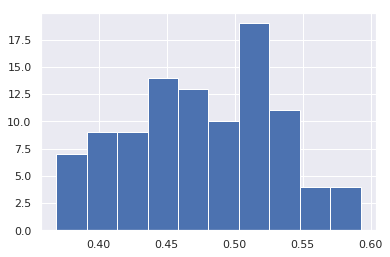

In [65]:
cv = ShuffleSplit(n_splits=100, test_size=0.4, random_state=0)

cv_results = cross_validate(model, X, y, scoring='r2', cv=cv,
                            n_jobs=-1, return_train_score=False)

plt.hist(cv_results['test_score']);

The histogram shows the distribution of `100` R squared test scores calculated from train/test pairs generated with the aforementioned strategy.

We will now apply the same procedure with the added complexity of varying one hyperparameter: `min_samples_split`. How it affects our model is of no interest to us at this time. 

To do so, we employ `GridSearchCV` to explore `30` values of `min_samples_split` between from `10` to `100`. Hence, since our cross-validation strategy is the same as before, this gives us a total of `30 * 100 = 3000` instances.

In [66]:
param_grid = {
    'min_samples_split': np.linspace(start=10, stop=100, num=30, dtype=int)
}

opt = GridSearchCV(model,
                   param_grid,
                   scoring='r2',
                   cv=cv,
                   return_train_score=True,
                   n_jobs=-1)

opt.fit(X, y);

`opt.cv_results` allows us to gain some insight with respect to our optimization strategy. With a bit of manipulation, we can generate a dataframe containing all our test scores, with each column representing a single value of `min_samples_split`.

In [67]:
results = pd.DataFrame(opt.cv_results_)

split_test_score_columns = [c for c in results.columns 
                            if c.startswith('split') and c.endswith('test_score')]

splits = (results
          .set_index('param_min_samples_split')
          [split_test_score_columns]
          .transpose())

splits

param_min_samples_split,10,13,...,96,100
split0_test_score,0.52,0.54,...,0.54,0.52
split1_test_score,0.54,0.55,...,0.55,0.55
...,...,...,...,...,...
split98_test_score,0.57,0.58,...,0.56,0.56
split99_test_score,0.60,0.60,...,0.54,0.54


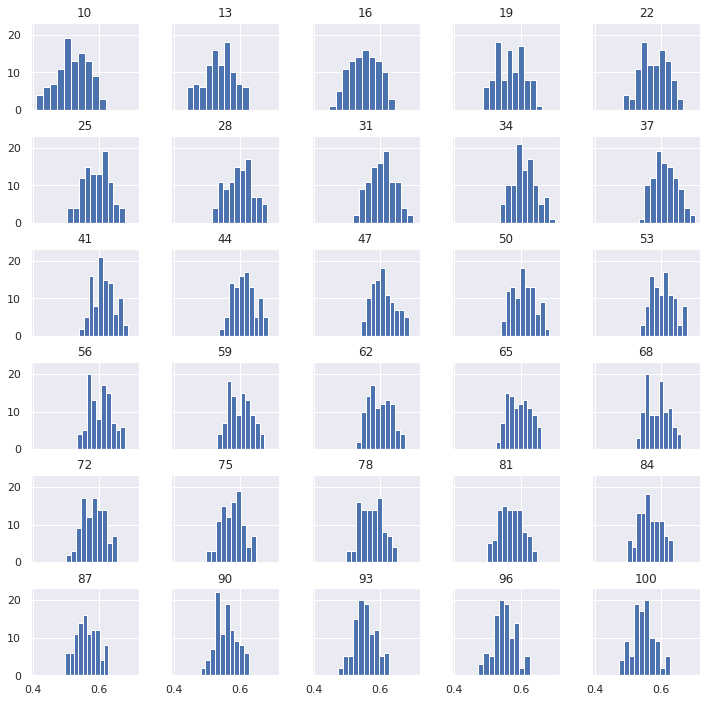

In [68]:
splits.hist(figsize=(12,12), sharex=True, sharey=True);

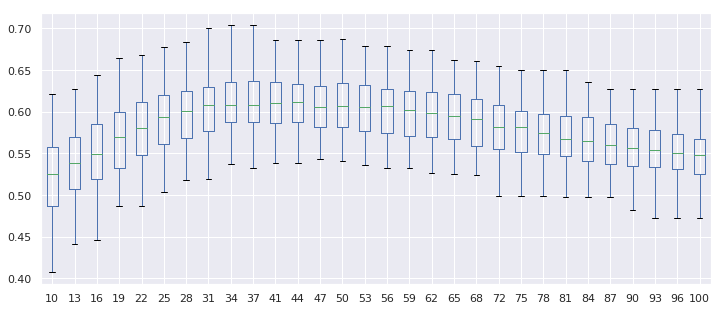

In [69]:
splits.boxplot(figsize=(12,5));

Notice how the median test scores vary smoothly. For a given value of `min_samples_split` neighboring points will have similar test scores. 

`GridSearchCV` does **not** take this into account, for we simply tell it to explore our parameter space almost exhaustively. 

Can we do better? Aye! The trick is to somehow *transfer* the knowledge we gain upon running our model for some value of `min_samples_split` to nearby points. The closer these points are to our current value, the better we can garuantee the similarity in performance. So, instead of treating each point independently, we will assume their distributions (loosely speaking, the histograms) are correlated.

We can easily do this with `skopt`, an optimization library built on top of `scikit-learn`.

In [84]:
dimensions = [Integer(10, 100, name='min_samples_split')]

@use_named_args(dimensions)
def objective(**params):
    model = DecisionTreeRegressor(random_state=0, **params)
    mean_loss = -cross_val_score(model, X, y, scoring='r2', n_jobs=-1, cv=cv).mean()
    print(params, mean_loss)
    return mean_loss

res = gp_minimize(objective, dimensions, n_calls=10, n_jobs=-1, random_state=0)

{'min_samples_split': 63} -0.596537802343955
{'min_samples_split': 86} -0.5633821374365953
{'min_samples_split': 87} -0.5619990228203495
{'min_samples_split': 86} -0.5633821374365953
{'min_samples_split': 66} -0.5923319355092533
{'min_samples_split': 45} -0.6112249370832981
{'min_samples_split': 37} -0.6111518813525008
{'min_samples_split': 15} -0.5468269564781781
{'min_samples_split': 35} -0.6107370182674395
{'min_samples_split': 53} -0.6061383402047038


Instead of passing a `param_grid` like in `GridSearchCV`, we define our parameters as dimensions. Here we are saying that `min_sample_split` is an integer value that lies between `10` and `100`. Our `objective` function defines the optimization problem at hand. Here we specify what we want to **minimize**. In this case it is the average value of our test scores given a certain cross-validation strategy, negated.

`gp_minimize` will call `objective` `10` times, changing the values each time for `min_samples_split` before-hand. This choice of which value to set is based on a strategy that draws inspiration from our previous analysis.